<a href="https://colab.research.google.com/github/racoope70/exploratory_daytrading/blob/main/ppo_alpaca_paper_trading_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Clean any partials
!pip uninstall -y stable-baselines3 shimmy gymnasium gym autorom AutoROM.accept-rom-license ale-py

# Install the compatible trio (no [extra] to avoid Atari deps)
!pip install "gymnasium==0.29.1" "shimmy==1.3.0" "stable-baselines3==2.3.0"

# Your other libs (safe to keep separate)
!pip install alpaca-trade-api ta python-dotenv gym-anytrading


Found existing installation: gymnasium 1.2.0
Uninstalling gymnasium-1.2.0:
  Successfully uninstalled gymnasium-1.2.0
Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
Found existing installation: ale-py 0.11.2
Uninstalling ale-py-0.11.2:
  Successfully uninstalled ale-py-0.11.2
Reason for being yanked: Loading broken with PyTorch 1.13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, which is not installed.
dopamine-rl 4.1.2 requires gym<=0.25.2, which is not installed.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.
  Preparing metadata (setup.py) ... done
  

In [2]:
import torch, gymnasium, shimmy, stable_baselines3 as sb3
import alpaca_trade_api, websockets, pywt

print("torch:", torch.__version__)
print("gymnasium:", gymnasium.__version__)
print("shimmy:", shimmy.__version__)
print("stable-baselines3:", sb3.__version__)
print("alpaca-trade-api:", alpaca_trade_api.__version__)
print("websockets:", websockets.__version__)
print("pywavelets:", pywt.__version__)


torch: 2.8.0+cu126
gymnasium: 0.29.1
shimmy: 1.3.0
stable-baselines3: 2.3.0
alpaca-trade-api: 3.2.0
websockets: 10.4
pywavelets: 1.8.0


In [3]:
import os, json, math, time, typing, numpy as np
import warnings

# Colab Drive (optional)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Use a PPO-specific output dir (rename from LightGBM)
RESULTS_DIR = "/content/drive/MyDrive/Alpaca_Results/PPO"
os.makedirs(RESULTS_DIR, exist_ok=True)

warnings.filterwarnings("ignore")


Mounted at /content/drive


In [4]:
from google.colab import files
uploaded = files.upload()  # Prompts you to upload the .env file for the key

Saving Alpaca_keys.env.txt to Alpaca_keys.env.txt


In [5]:
import os

# Rename to .env so dotenv can recognize it
os.rename("Alpaca_keys.env.txt", ".env")

In [6]:
from google.colab import files
uploaded = files.upload()  # Upload: model_ABT.txt, features_ABT.txt, scaler_ABT.pkl


Saving ppo_UNH_window3_features.json to ppo_UNH_window3_features.json
Saving ppo_UNH_window3_model_info.json to ppo_UNH_window3_model_info.json
Saving ppo_UNH_window3_model.zip to ppo_UNH_window3_model.zip
Saving ppo_UNH_window3_probability_config.json to ppo_UNH_window3_probability_config.json
Saving ppo_UNH_window3_vecnorm.pkl to ppo_UNH_window3_vecnorm.pkl


ARTIFACTS_DIR = /content
Exists: True
Artifacts present: ['ppo_UNH_window3_features.json', 'ppo_UNH_window3_model.zip', 'ppo_UNH_window3_model_info.json', 'ppo_UNH_window3_probability_config.json', 'ppo_UNH_window3_vecnorm.pkl']
DRY_RUN = True | BARS_FEED = iex
BEFORE override -> SIZING_MODE: linear | CONF_FLOOR: 0.2
SIZING_MODE: linear -> threshold
CONF_FLOOR:  0.20 -> 0.10
AFTER  override -> SIZING_MODE: threshold | CONF_FLOOR: 0.1
TAKE_PROFIT_PCT: 0.0500 -> 0.0500
STOP_LOSS_PCT:   0.0300 -> 0.0300
expected obs shape: (10, 2)

Running strategy for UNH...
Model artifacts loaded for UNH
Prediction for UNH: 0 (1 = Buy, 0 = Sell)
raw=-0.3441 conf=0.331 target_w=0.000 price=$359.10 equity=$100,073.91
Market is closed.

========== SUMMARY ==========
Processed:         1
Models loaded:     1
Predictions made:  1
Market closed:     1
Orders submitted:  0 (dry_run=True)
Existing positions (start -> end): 6 -> 6
Open orders        (start -> end): 0 -> 0


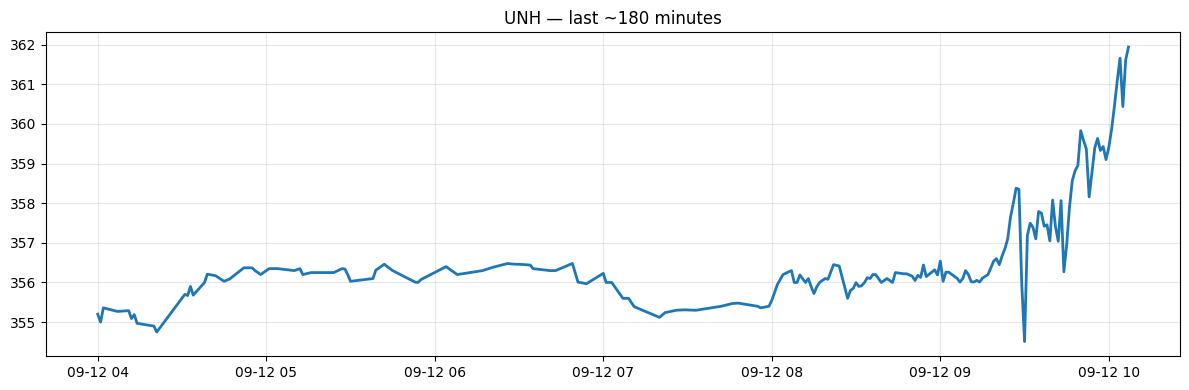

/content/trade_log_UNH.csv
                           log_time symbol                   bar_time  \
0  2025-09-12T20:05:15.721586+00:00    UNH  2025-09-12T16:07:00+00:00   

         signal  raw_action  weight  confidence  price     equity  dry_run  \
0  SELL_OR_HOLD   -0.344103     0.0    0.331135  359.1  100073.91        1   

         note  
0  diagnostic  


In [7]:
# ======================= UNH PPO Paper-Trading — End-to-End Script =======================
# One cell / one file version. Defaults to DRY_RUN (log only). Set DRY_RUN=0 to place paper orders.

# --- Imports & logging -------------------------------------------------------------------
import os, re, json, csv, shutil, logging, pickle, warnings, time, math
from pathlib import Path
from datetime import datetime, timedelta, timezone
from typing import Dict, Optional, Tuple, Any, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame, APIError
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecNormalize

warnings.filterwarnings("ignore")
load_dotenv(override=True)
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

# --- Alpaca API init ---------------------------------------------------------------------
API_KEY    = os.getenv("APCA_API_KEY_ID")     or os.getenv("ALPACA_API_KEY_ID")     or ""
API_SECRET = os.getenv("APCA_API_SECRET_KEY") or os.getenv("ALPACA_API_SECRET_KEY") or ""
BASE_URL   = os.getenv("APCA_API_BASE_URL")   or os.getenv("ALPACA_API_BASE_URL")   or "https://paper-api.alpaca.markets"

if __name__ == "__main__":
    # --- Force paper account + allow orders to be sent to PAPER ---
    BASE_URL = "https://paper-api.alpaca.markets"   # ensure we talk to paper API
    os.environ["DRY_RUN"] = "0"                     # 0 => place paper orders
    DRY_RUN = os.getenv("DRY_RUN", "1").lower() in ("1","true","yes")
    print("DRY_RUN =", DRY_RUN)  # should print False

    logging.info("Keys loaded: %s/%s | BASE_URL=%s", bool(API_KEY), bool(API_SECRET), BASE_URL)
    try:
        api = init_alpaca()
        acct = api.get_account()
        logging.info("Account status: %s | equity=%s | cash=%s", acct.status, acct.cash, acct.equity)
    except Exception as e:
        logging.exception("Failed to initialize Alpaca: %s", e)
        raise

def init_alpaca() -> "tradeapi.REST":
    if not API_KEY or not API_SECRET:
        raise RuntimeError("Missing Alpaca API keys.")
    api = tradeapi.REST(API_KEY, API_SECRET, base_url=BASE_URL)
    _ = api.get_account()  # sanity
    return api

# --- Runtime knobs (env-driven) ----------------------------------------------------------
ARTIFACTS_DIR     = os.getenv("ARTIFACTS_DIR", "/content")
BEST_WINDOW_ENV   = (os.getenv("BEST_WINDOW", "").strip() or None)  # e.g., "3"
TICKERS           = [s.strip() for s in os.getenv("TICKERS", "UNH").split(",") if s.strip()]
BARS_FEED         = os.getenv("BARS_FEED", "iex").strip()
DRY_RUN           = os.getenv("DRY_RUN", "1").lower() in ("1","true","yes")
INF_DETERMINISTIC = os.getenv("INF_DETERMINISTIC", "1").lower() in ("1","true","yes")
COOLDOWN_MIN      = int(os.getenv("COOLDOWN_MIN", "1"))
STALE_MAX_SEC     = int(os.getenv("STALE_MAX_SEC", "120"))

# Sizing / TP-SL
SIZING_MODE     = os.getenv("SIZING_MODE", "linear")        # "linear" | "threshold"
WEIGHT_CAP      = float(os.getenv("WEIGHT_CAP", "0.10"))    # Max portfolio weight for a symbol
CONF_FLOOR      = float(os.getenv("CONF_FLOOR", "0.20"))    # Threshold mode only
TAKE_PROFIT_PCT = float(os.getenv("TAKE_PROFIT_PCT", "0.05"))  # e.g., 0.05 = +5%
STOP_LOSS_PCT   = float(os.getenv("STOP_LOSS_PCT", "0.03"))    # e.g., 0.03 = -3%

# --- Small time utils --------------------------------------------------------------------
def now_utc() -> datetime:
    return datetime.now(timezone.utc)

def utc_ts(dt_like) -> int:
    try:
        return int(pd.Timestamp(dt_like, tz="UTC").timestamp())
    except Exception:
        return int(datetime.fromtimestamp(float(dt_like), tz=timezone.utc).timestamp())
# --- Helper: re-read sizing knobs from environment --------------------------------------
def apply_env_overrides(verbose: bool = False):
    """
    Re-read SIZING_MODE / CONF_FLOOR from environment and update the globals.
    Call this AFTER you set os.environ[...] and BEFORE running inference.
    """
    global SIZING_MODE, CONF_FLOOR
    old_mode, old_floor = SIZING_MODE, CONF_FLOOR
    SIZING_MODE = os.getenv("SIZING_MODE", SIZING_MODE)
    CONF_FLOOR  = float(os.getenv("CONF_FLOOR", str(CONF_FLOOR)))
    if verbose:
        print(f"SIZING_MODE: {old_mode} -> {SIZING_MODE}")
        print(f"CONF_FLOOR:  {old_floor:.2f} -> {CONF_FLOOR:.2f}")
def apply_risk_overrides(verbose: bool = True):
    """Re-read TAKE_PROFIT_PCT / STOP_LOSS_PCT from env and update globals."""
    global TAKE_PROFIT_PCT, STOP_LOSS_PCT
    old_tp, old_sl = TAKE_PROFIT_PCT, STOP_LOSS_PCT
    TAKE_PROFIT_PCT = float(os.getenv("TAKE_PROFIT_PCT", str(TAKE_PROFIT_PCT)))
    STOP_LOSS_PCT   = float(os.getenv("STOP_LOSS_PCT",   str(STOP_LOSS_PCT)))
    if verbose:
        print(f"TAKE_PROFIT_PCT: {old_tp:.4f} -> {TAKE_PROFIT_PCT:.4f}")
        print(f"STOP_LOSS_PCT:   {old_sl:.4f} -> {STOP_LOSS_PCT:.4f}")

# =========================================================================================
# Artifacts & CSV logging
# =========================================================================================
RESULTS_DIR = Path(os.getenv("RESULTS_DIR", ARTIFACTS_DIR))
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

def _append_csv_row(path: Path, row: dict):
    write_header = not path.exists()
    with path.open("a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=row.keys())
        if write_header:
            w.writeheader()
        w.writerow(row)

def log_trade(symbol: str,
              bar_time,            # pandas/np datetime or ISO
              signal: int,         # 1=Buy, 0=Sell/Hold
              raw_action: float,   # PPO raw action
              weight: float,       # target portfolio weight
              confidence: float,   # |tanh(raw_action)|
              price: float,        # last price
              equity: float,       # account equity
              dry_run: bool,
              note: str = ""):
    try:
        bt_iso = pd.to_datetime(bar_time, utc=True).isoformat()
    except Exception:
        bt_iso = ""
    row = {
        "log_time": now_utc().isoformat(),
        "symbol": symbol,
        "bar_time": bt_iso,
        "signal": "BUY" if int(signal) == 1 else "SELL_OR_HOLD",
        "raw_action": float(raw_action) if np.isfinite(raw_action) else "",
        "weight": float(weight) if np.isfinite(weight) else "",
        "confidence": float(confidence) if np.isfinite(confidence) else "",
        "price": float(price) if np.isfinite(price) else "",
        "equity": float(equity) if np.isfinite(equity) else "",
        "dry_run": int(bool(dry_run)),
        "note": note,
    }
    _append_csv_row(RESULTS_DIR / f"trade_log_{symbol}.csv", row)

# Optional: copy artifacts into ARTIFACTS_DIR if found in Drive
ART_DIR = Path(ARTIFACTS_DIR)
CANDIDATE_DRIVE_ROOTS = [Path("/content/drive/MyDrive"), Path("/content/drive")]
if BEST_WINDOW_ENV:
    need = [
        f"ppo_UNH_window{BEST_WINDOW_ENV}_model.zip",
        f"ppo_UNH_window{BEST_WINDOW_ENV}_vecnorm.pkl",
        f"ppo_UNH_window{BEST_WINDOW_ENV}_features.json",
    ]
else:
    # Fallback names if window not encoded
    need = [
        "ppo_UNH_model.zip",
        "ppo_UNH_vecnorm.pkl",
        "ppo_UNH_features.json",
    ]

for name in need:
    dst = ART_DIR / name
    if dst.exists():
        continue
    src = None
    for root in CANDIDATE_DRIVE_ROOTS:
        try:
            src = next(root.rglob(name))
            break
        except StopIteration:
            continue
    if src:
        dst.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(src, dst)

print("ARTIFACTS_DIR =", ART_DIR)
print("Exists:", ART_DIR.exists())
print("Artifacts present:", sorted(p.name for p in ART_DIR.glob("ppo_UNH*")))
print("DRY_RUN =", DRY_RUN, "| BARS_FEED =", BARS_FEED)

# =========================================================================================
# Feature engineering & observation builders (live-time)
# =========================================================================================
def normalize_ohlcv_cols(df: pd.DataFrame) -> pd.DataFrame:
    cols_ci = {c.lower(): c for c in df.columns}
    want = {
        "Open":      ["open"],
        "High":      ["high"],
        "Low":       ["low"],
        "Close":     ["close", "close*", "last"],
        "Adj Close": ["adj close", "adj_close", "adjclose", "adjusted close"],
        "Volume":    ["volume", "vol"],
    }
    rename = {}
    for final, alts in want.items():
        for a in [final.lower()] + alts:
            if a in cols_ci:
                rename[cols_ci[a]] = final
                break
    out = df.rename(columns=rename).copy()
    if "Adj Close" not in out.columns and "Close" in out.columns:
        out["Adj Close"] = out["Close"]
    return out

def denoise_wavelet(series: pd.Series, wavelet: str = "db1", level: int = 2) -> pd.Series:
    try:
        import pywt
    except Exception:
        return pd.Series(series).astype(float).ewm(span=5, adjust=False).mean()
    s = pd.Series(series).astype(float).ffill().bfill()
    arr = s.to_numpy()
    try:
        w = pywt.Wavelet(wavelet)
        maxlvl = pywt.dwt_max_level(len(arr), w.dec_len)
        lvl = int(max(0, min(level, maxlvl)))
        if lvl < 1:
            return s
        coeffs = pywt.wavedec(arr, w, mode="symmetric", level=lvl)
        for i in range(1, len(coeffs)):
            coeffs[i] = np.zeros_like(coeffs[i])
        rec = pywt.waverec(coeffs, w, mode="symmetric")
        return pd.Series(rec[:len(arr)], index=s.index)
    except Exception:
        return s.ewm(span=5, adjust=False).mean()

def add_regime(df: pd.DataFrame) -> pd.DataFrame:
    df["Vol20"] = df["Close"].pct_change().rolling(20).std()
    df["Ret20"] = df["Close"].pct_change(20)
    vol_hi   = (df["Vol20"] > df["Vol20"].median()).astype(int)
    trend_hi = (df["Ret20"].abs() > df["Ret20"].abs().median()).astype(int)
    df["Regime4"] = vol_hi * 2 + trend_hi
    return df

def add_features_live(
    df: pd.DataFrame,
    use_sentiment: bool = False,
    rsi_wilder: bool = True,
    atr_wilder: bool = True,
) -> pd.DataFrame:
    df = normalize_ohlcv_cols(df).copy().sort_index()

    # Bollinger
    df["SMA_20"] = df["Close"].rolling(20).mean()
    df["STD_20"] = df["Close"].rolling(20).std()
    df["Upper_Band"] = df["SMA_20"] + 2 * df["STD_20"]
    df["Lower_Band"] = df["SMA_20"] - 2 * df["STD_20"]

    # Stochastic
    df["Lowest_Low"]   = df["Low"].rolling(14).min()
    df["Highest_High"] = df["High"].rolling(14).max()
    denom = (df["Highest_High"] - df["Lowest_Low"]).replace(0, np.nan)
    df["Stoch"] = ((df["Close"] - df["Lowest_Low"]) / denom) * 100

    # Momentum / volume / CCI
    df["ROC"] = df["Close"].pct_change(10)
    sign = np.sign(df["Close"].diff().fillna(0))
    df["OBV"] = (sign * df["Volume"].fillna(0)).cumsum()

    tp = (df["High"] + df["Low"] + df["Close"]) / 3.0
    sma_tp = tp.rolling(20).mean()
    md = (tp - sma_tp).abs().rolling(20).mean().replace(0, np.nan)
    df["CCI"] = (tp - sma_tp) / (0.015 * md)

    # EMAs + MACD
    df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()
    df["EMA_50"] = df["Close"].ewm(span=50, adjust=False).mean()
    ema12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD_Line"]   = ema12 - ema26
    df["MACD_Signal"] = df["MACD_Line"].ewm(span=9, adjust=False).mean()

    # RSI (Wilder default)
    d = df["Close"].diff()
    gain = d.clip(lower=0)
    loss = (-d.clip(upper=0))
    if rsi_wilder:
        avg_gain = gain.ewm(alpha=1/14, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/14, adjust=False).mean()
    else:
        avg_gain = gain.rolling(14).mean()
        avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    df["RSI"] = 100 - (100 / (1 + rs))

    # ATR (Wilder)
    tr = pd.concat([
        (df["High"] - df["Low"]),
        (df["High"] - df["Close"].shift()).abs(),
        (df["Low"]  - df["Close"].shift()).abs(),
    ], axis=1).max(axis=1)
    df["ATR"] = tr.ewm(alpha=1/14, adjust=False).mean() if atr_wilder else tr.rolling(14).mean()

    # Vol + denoised close
    df["Volatility"]   = df["Close"].pct_change().rolling(20).std()
    df["Denoised_Close"] = denoise_wavelet(df["Close"])

    # Regime + simple “Greeks” proxies + optional sentiment
    df = add_regime(df)
    df["SentimentScore"] = (df.get("SentimentScore", 0.0) if use_sentiment else 0.0)
    df["Delta"] = df["Close"].pct_change(1).fillna(0.0)
    df["Gamma"] = df["Delta"].diff().fillna(0.0)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

def compute_art_feat_order(features_hint: Any, df: pd.DataFrame) -> List[str]:
    if features_hint is None:
        return [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    feats = features_hint.get("features", features_hint) if isinstance(features_hint, dict) else list(features_hint)
    drop = {"datetime", "symbol", "target", "return"}
    return [c for c in feats if c not in drop and (c in df.columns) and pd.api.types.is_numeric_dtype(df[c])]

def build_obs_from_row(row: pd.Series, order: List[str]) -> np.ndarray:
    vals = []
    for c in order:
        v = row.get(c, np.nan)
        vals.append(0.0 if (pd.isna(v) or v is None or v is False) else float(v))
    return np.array(vals, dtype=np.float32)

def expected_obs_shape(model, vecnorm) -> Optional[tuple]:
    for src in (vecnorm, model):
        try:
            shp = tuple(src.observation_space.shape)
            if shp:
                return shp
        except Exception:
            pass
    return None

def _pick_columns_for_channels(features_hint: Any, df: pd.DataFrame, channels: int) -> List[str]:
    numeric = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cols: List[str] = []
    if isinstance(features_hint, dict) and "features" in features_hint:
        cand = [c for c in features_hint["features"] if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
        if len(cand) >= channels:
            cols = cand[:channels]
    if not cols:
        pref = ["Close", "Volume", "Adj Close", "Open", "High", "Low"]
        cols = [c for c in pref if c in numeric]
        cols += [c for c in numeric if c not in cols]
        cols = cols[:channels]
    if len(cols) < channels and cols:
        while len(cols) < channels:
            cols.append(cols[-1])
    return cols[:channels]

def prepare_observation_from_bars(
    bars_df: pd.DataFrame,
    features_hint: Any = None,
    min_required_rows: int = 60,
    expected_shape: Optional[tuple] = None,
) -> Tuple[np.ndarray, int]:
    feats_df = add_features_live(bars_df).replace([np.inf, -np.inf], np.nan)

    ts = pd.Timestamp.utcnow()
    try:
        idx_ts = pd.Timestamp(feats_df.index[-1])
        ts = idx_ts.tz_convert("UTC") if idx_ts.tzinfo else idx_ts.tz_localize("UTC")
    except Exception:
        pass

    if expected_shape is not None and len(expected_shape) == 2:
        lookback, channels = int(expected_shape[0]), int(expected_shape[1])
        cols = _pick_columns_for_channels(features_hint, feats_df, channels)
        window_df = feats_df[cols].tail(lookback)
        arr = window_df.to_numpy(dtype=np.float32)
        if arr.shape[0] < lookback:
            pad_rows = lookback - arr.shape[0]
            arr = np.vstack([np.zeros((pad_rows, channels), dtype=np.float32), arr])
        arr = arr[-lookback:, :channels]
        return arr.reshape(lookback, channels), int(ts.timestamp())

    order = compute_art_feat_order(features_hint, feats_df)
    if not order:
        raise ValueError("No usable features after resolving artifact order.")
    feats_df = feats_df.dropna(subset=order)
    if len(feats_df) < max(20, min_required_rows):
        raise ValueError(f"Not enough bars to compute features robustly (have {len(feats_df)}).")
    last = feats_df.iloc[-1]
    obs = build_obs_from_row(last, order)
    return obs.astype(np.float32), int(ts.timestamp())

# =========================================================================================
# Market data + account helpers
# =========================================================================================
def get_recent_bars(api, symbol: str, limit: int = 200, timeframe=TimeFrame.Minute) -> pd.DataFrame:
    def _as_df(bars):
        if hasattr(bars, "df"):
            df = bars.df.copy()
            if not df.empty:
                if isinstance(df.index, pd.MultiIndex):
                    df = df.xs(symbol, level=0)
                df.index = pd.to_datetime(df.index, utc=True)
                df = df.rename(columns={"open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})
                cols = [c for c in ["Open","High","Low","Close","Volume"] if c in df.columns]
                return df[cols].sort_index()
            return pd.DataFrame(columns=["Open","High","Low","Close","Volume"])
        rows = []
        for b in bars:
            ts = getattr(b, "t", None)
            ts = pd.to_datetime(ts, utc=True) if ts is not None else pd.NaT
            rows.append({
                "timestamp": ts,
                "Open":   float(getattr(b, "o", getattr(b, "open",  np.nan))),
                "High":   float(getattr(b, "h", getattr(b, "high",  np.nan))),
                "Low":    float(getattr(b, "l", getattr(b, "low",   np.nan))),
                "Close":  float(getattr(b, "c", getattr(b, "close", np.nan))),
                "Volume": float(getattr(b, "v", getattr(b, "volume",np.nan))),
            })
        df = pd.DataFrame(rows)
        if df.empty:
            return pd.DataFrame(columns=["Open","High","Low","Close","Volume"])
        return df.set_index(pd.to_datetime(df["timestamp"], utc=True)).drop(columns=["timestamp"]).sort_index()

    feed = os.getenv("BARS_FEED", "").strip()
    try:
        logging.info(f"[{symbol}] fetching {limit} {timeframe} bars (feed='{feed or 'default'}')")
        bars = api.get_bars(symbol, timeframe, limit=limit, feed=feed) if feed else api.get_bars(symbol, timeframe, limit=limit)
        df = _as_df(bars)
        if not df.empty:
            return df
    except Exception as e:
        logging.warning(f"[{symbol}] get_bars(limit) failed: {e}")

    # Fallback 5-day window
    try:
        end   = datetime.utcnow().replace(microsecond=0).isoformat() + "Z"
        start = (datetime.utcnow() - timedelta(days=5)).replace(microsecond=0).isoformat() + "Z"
        logging.info(f"[{symbol}] retry with window start={start} end={end} (feed='{feed or 'default'}')")
        bars = api.get_bars(symbol, timeframe, start=start, end=end, feed=feed) if feed else api.get_bars(symbol, timeframe, start=start, end=end)
        return _as_df(bars)
    except Exception as e:
        logging.warning(f"[{symbol}] get_bars(start/end) failed: {e}")
        return pd.DataFrame(columns=["Open","High","Low","Close","Volume"])

def get_account_equity(api) -> float:
    return float(api.get_account().equity)

def get_position(api, symbol: str):
    try:
        return api.get_position(symbol)
    except Exception:
        return None

def get_position_qty(api, symbol: str) -> int:
    pos = get_position(api, symbol)
    if not pos:
        return 0
    try:
        return int(float(pos.qty))
    except Exception:
        return 0

def get_last_price(api, symbol: str) -> float:
    try:
        bars = api.get_bars(symbol, TimeFrame.Minute, limit=1, feed=os.getenv("BARS_FEED","") or None)
        if hasattr(bars, "df"):
            df = bars.df.copy()
            if isinstance(df.index, pd.MultiIndex):
                df = df.xs(symbol, level=0)
            if not df.empty:
                # Alpaca names are usually lowercase in df
                if "close" in df.columns: return float(df["close"].iloc[-1])
                if "Close" in df.columns: return float(df["Close"].iloc[-1])
        else:
            if len(bars) > 0:
                b = bars[0]
                close = getattr(b, "c", getattr(b, "close", None))
                if close is not None: return float(close)
    except Exception as e:
        logging.warning(f"[{symbol}] get_last_price via bars failed: {e}")
    try:
        pos = api.get_position(symbol)
        return float(pos.avg_entry_price)
    except Exception:
        return float("nan")

def cancel_open_symbol_orders(api, symbol: str):
    try:
        for o in api.list_orders(status="open"):
            if o.symbol == symbol:
                api.cancel_order(o.id)
    except Exception as e:
        logging.warning(f"[{symbol}] cancel orders failed: {e}")

def market_order_to_qty(api, symbol: str, side: str, qty: int):
    if qty <= 0:
        return None
    if DRY_RUN:
        logging.info(f"[DRY_RUN] Would submit {side} {qty} {symbol} (market, day)")
        return None
    try:
        o = api.submit_order(
            symbol=symbol,
            side=side,
            type="market",
            qty=qty,
            time_in_force="day"
        )
        logging.info(f"[{symbol}] Submitted {side} {qty} (market) id={o.id}")
        return o
    except Exception as e:
        logging.error(f"[{symbol}] submit_order failed: {e}")
        return None

# =========================================================================================
# Sizing / risk + (un)flatten + rebalancer
# =========================================================================================
def action_to_weight(action) -> Tuple[float, float, float]:
    a = float(np.array(action).squeeze())
    conf = float(abs(np.tanh(a)))
    if a <= 0:
        return 0.0, conf, a
    if SIZING_MODE == "linear":
        w = WEIGHT_CAP * conf
    else:
        w = 0.0 if conf < CONF_FLOOR else WEIGHT_CAP * (conf - CONF_FLOOR) / (1.0 - CONF_FLOOR)
    w = max(0.0, min(WEIGHT_CAP, float(w)))
    return w, conf, a

MIN_POS_QTY = 1

def compute_target_qty(equity: float, price: float, target_weight: float) -> int:
    if not np.isfinite(price) or price <= 0:
        return 0
    notional = equity * target_weight
    qty = int(notional // price)
    if target_weight > 0 and qty == 0:
        return MIN_POS_QTY
    return max(0, qty)

def compute_target_qty_by_cash(equity: float, price: float, target_weight: float, api=None) -> int:
    if not np.isfinite(price) or price <= 0:
        return 0
    cash_cap = float(api.get_account().cash) if api else equity
    notional = min(cash_cap, equity * target_weight)
    qty = int(notional // price)
    if target_weight > 0 and qty == 0 and notional >= price:
        return 1
    return max(0, qty)

def flatten_symbol(api, symbol: str):
    qty = get_position_qty(api, symbol)
    if qty == 0:
        return
    cancel_open_symbol_orders(api, symbol)
    side = "sell" if qty > 0 else "buy"
    market_order_to_qty(api, symbol, side, abs(qty))

def rebalance_to_weight(api, symbol: str, equity: float, target_weight: float):
    if target_weight <= 0:
        flatten_symbol(api, symbol)
        return
    price    = get_last_price(api, symbol)
    if not np.isfinite(price) or price <= 0:
        logging.warning(f"[{symbol}] Price unavailable; skipping rebalance this cycle.")
        return
    have_qty = get_position_qty(api, symbol)
    want_qty = compute_target_qty_by_cash(equity, price, target_weight, api)
    delta    = want_qty - have_qty
    if delta == 0:
        return
    side = "buy" if delta > 0 else "sell"
    market_order_to_qty(api, symbol, side, abs(delta))

def check_tp_sl_and_maybe_flatten(api, symbol: str) -> bool:
    if TAKE_PROFIT_PCT <= 0 and STOP_LOSS_PCT <= 0:
        return False
    pos = get_position(api, symbol)
    if not pos:
        return False
    try:
        plpc = float(pos.unrealized_plpc)  # +0.031 = +3.1%
    except Exception:
        return False
    if TAKE_PROFIT_PCT > 0 and plpc >= TAKE_PROFIT_PCT:
        logging.info(f"[{symbol}] TP hit ({plpc:.4f} >= {TAKE_PROFIT_PCT:.4f}). Flattening.")
        flatten_symbol(api, symbol)
        return True
    if STOP_LOSS_PCT > 0 and plpc <= -abs(STOP_LOSS_PCT):
        logging.info(f"[{symbol}] SL hit ({plpc:.4f} <= {-abs(STOP_LOSS_PCT):.4f}). Flattening.")
        flatten_symbol(api, symbol)
        return True
    return False

# =========================================================================================
# Artifact picker & loaders
# =========================================================================================
def _extract_window_idx(path: Path) -> Optional[int]:
    m = re.search(r"_window(\d+)_", path.stem, re.IGNORECASE)
    if not m:
        return None
    try:
        return int(m.group(1))
    except Exception:
        return None

def pick_artifacts_for_ticker(
    ticker: str,
    artifacts_dir: str,
    best_window: Optional[str] = None
) -> Dict[str, Optional[Path]]:
    p = Path(artifacts_dir)
    if not p.exists():
        raise FileNotFoundError(f"Artifacts directory not found: {p.resolve()}")

    models = sorted(p.glob(f"ppo_{ticker}_window*_model.zip"))
    if not models:
        models = sorted(p.glob(f"ppo_{ticker}_model.zip")) or sorted(p.glob(f"*{ticker}*model.zip"))
        if not models:
            found = "\n".join(f" - {x}" for x in p.rglob("*model.zip"))
            raise FileNotFoundError(f"No PPO model for {ticker} in {p.resolve()}.\nSeen:\n{found or ' (none)'}")

    chosen: Optional[Path] = None
    if best_window:
        chosen = next((m for m in models if f"_window{best_window}_" in m.stem), None)
        if chosen is None:
            logging.warning("BEST_WINDOW=%s not found; falling back to best available.", best_window)

    if chosen is None:
        with_idx = [(m, _extract_window_idx(m)) for m in models]
        with_idx = [(m, w) for (m, w) in with_idx if w is not None]
        chosen = max(with_idx, key=lambda t: t[1])[0] if with_idx else models[-1]

    base    = chosen.stem.replace("_model", "")
    vecnorm = next(iter(sorted(p.glob(base + "_vecnorm.pkl"))), None)
    feats   = next(iter(sorted(p.glob(base + "_features.json"))), None)

    logging.info(f"[{ticker}] model={chosen.name} | vecnorm={bool(vecnorm)} | features={bool(feats)}")
    return {"model": chosen, "vecnorm": vecnorm, "features": feats}

def load_vecnormalize(path: Optional[Path]):
    if path is None:
        return None
    with open(path, "rb") as f:
        return pickle.load(f)

def load_features(path: Optional[Path]):
    if path is None:
        return None
    with open(path, "r") as f:
        return json.load(f)

def load_ppo_model(model_path: Path):
    return PPO.load(str(model_path))

# =========================================================================================
# Inference helpers
# =========================================================================================
def infer_target_weight(model: PPO, vecnorm: Optional[VecNormalize], obs: np.ndarray) -> Tuple[float, float, float]:
    x = obs
    if vecnorm is not None and hasattr(vecnorm, "normalize_obs"):
        try:
            x = vecnorm.normalize_obs(x)
        except Exception as e:
            logging.warning(f"VecNormalize.normalize_obs failed; using raw obs. Err: {e}")
    action, _ = model.predict(x, deterministic=INF_DETERMINISTIC)
    return action_to_weight(action)

# =========================================================================================
# Live step & loop (optional)
# =========================================================================================
def ensure_market_open(api) -> bool:
    try:
        return bool(api.get_clock().is_open)
    except Exception:
        return False

def run_live_once_for_symbol(api, symbol: str, model: PPO, vecnorm: Optional[VecNormalize], features_hint: Optional[dict] = None):
    shape = expected_obs_shape(model, vecnorm)
    bars_df = get_recent_bars(api, symbol, limit=200, timeframe=TimeFrame.Minute)
    if bars_df.empty:
        logging.warning(f"[{symbol}] No recent bars; skipping.")
        return
    obs, obs_ts = prepare_observation_from_bars(
        bars_df,
        features_hint=features_hint,
        min_required_rows=60,
        expected_shape=shape,
    )
    if utc_ts(now_utc()) - obs_ts > STALE_MAX_SEC:
        logging.warning(f"[{symbol}] Observation stale (> {STALE_MAX_SEC}s). Skipping.")
        return

    if check_tp_sl_and_maybe_flatten(api, symbol):
        return

    target_w, conf, raw = infer_target_weight(model, vecnorm, obs)
    eq = get_account_equity(api)
    logging.info(f"[{symbol}] action={raw:.4f} conf={conf:.3f} → target_w={target_w:.3f} | equity=${eq:,.2f}")
    bar_time = bars_df.index[-1] if not bars_df.empty else pd.NaT
    price    = float(bars_df["Close"].iloc[-1]) if not bars_df.empty else get_last_price(api, symbol)
    log_trade(symbol, bar_time, int(target_w > 0.0), raw, target_w, conf, price, eq, DRY_RUN, note="live")

    rebalance_to_weight(api, symbol, eq, target_w)

def run_live(tickers: List[str]):
    api = init_alpaca()
    per_ticker: Dict[str, Tuple[PPO, Optional[VecNormalize], Optional[dict]]] = {}
    for t in tickers:
        picks      = pick_artifacts_for_ticker(t, ARTIFACTS_DIR, best_window=BEST_WINDOW_ENV)
        model      = load_ppo_model(picks["model"])
        vecnorm    = load_vecnormalize(picks["vecnorm"]) if picks["vecnorm"] else None
        feat_order = load_features(picks["features"])
        per_ticker[t] = (model, vecnorm, feat_order)

    logging.info(f"Starting live execution for: {tickers}")
    last_exec_at = now_utc() - timedelta(minutes=COOLDOWN_MIN)

    while True:
        try:
            if not ensure_market_open(api):
                logging.info("Market closed. Sleeping 30s.")
                time.sleep(30)
                continue

            if (now_utc() - last_exec_at) < timedelta(minutes=COOLDOWN_MIN):
                time.sleep(5)
                continue

            for t in tickers:
                model, vecnorm, feat_hint = per_ticker[t]
                run_live_once_for_symbol(api, t, model, vecnorm, features_hint=feat_hint)

            last_exec_at = now_utc()

        except KeyboardInterrupt:
            logging.info("KeyboardInterrupt: stopping live loop.")
            break
        except Exception as e:
            logging.exception(f"Live loop exception: {e}")
            time.sleep(5)

# =========================================================================================
# UNH Diagnostic (one-off; works even if market closed; respects DRY_RUN)
# =========================================================================================
def unh_diagnostic(dry_run: bool = DRY_RUN,
                   timeframe: TimeFrame = TimeFrame.Minute,
                   limit: int = 300):
    ticker = "UNH"
    print(f"\nRunning strategy for {ticker}...")

    # Snapshot start
    try:
        api = init_alpaca()
        positions_start = len(api.list_positions())
        orders_start    = len(api.list_orders(status="open"))
    except Exception as e:
        print(f"Error initializing Alpaca: {e}")
        return

    # Load artifacts
    try:
        best   = (os.getenv("BEST_WINDOW", "").strip() or None)
        picks  = pick_artifacts_for_ticker(ticker, os.getenv("ARTIFACTS_DIR", "/content"), best_window=best)
        model  = load_ppo_model(picks["model"])
        vecnorm = load_vecnormalize(picks["vecnorm"]) if picks["vecnorm"] else None
        feats   = load_features(picks["features"])
        print(f"Model artifacts loaded for {ticker}")
    except Exception as e:
        print(f"Could not load model for {ticker}: {e}")
        return

    # Bars / shape-aware requirements
    try:
        shape    = expected_obs_shape(model, vecnorm)
        lookback = int(shape[0]) if (shape is not None and len(shape) == 2) else None
        bars_need = max(200, (lookback or 0) * 3)
        bars_df  = get_recent_bars(api, ticker, limit=max(limit, bars_need), timeframe=timeframe)

        min_rows_needed = lookback if lookback is not None else 60
        if len(bars_df) < min_rows_needed:
            print(f"Not enough data for {ticker}: {len(bars_df)} rows (need ≥ {min_rows_needed})")
            bars_df = pd.DataFrame()
    except Exception as e:
        print(f"Error fetching bars for {ticker}: {e}")
        bars_df = pd.DataFrame()

    # Build observation
    obs, obs_ts = None, None
    if not bars_df.empty:
        try:
            obs, obs_ts = prepare_observation_from_bars(
                bars_df,
                features_hint=feats,
                min_required_rows=min_rows_needed,
                expected_shape=shape,
            )
        except Exception as e:
            print(f"Error preparing observation for {ticker}: {e}")

    # Predict
    signal = None
    target_w = conf = raw = float("nan")
    predictions_made = 0
    bar_time = pd.NaT
    price = float("nan")
    equity = float("nan")

    # Ensure summary fields are always defined
    orders_submitted = 0
    market_closed = 0

    if obs is not None:
        try:
            target_w, conf, raw = infer_target_weight(model, vecnorm, obs)
            signal = int(target_w > 0.0)  # 1 = Buy, 0 = Sell/Hold
            predictions_made = 1
            print(f"Prediction for {ticker}: {signal} (1 = Buy, 0 = Sell)")

            # Debug details
            bar_time = bars_df.index[-1] if not bars_df.empty else pd.NaT
            price    = float(bars_df["Close"].iloc[-1]) if not bars_df.empty else get_last_price(api, ticker)
            equity   = get_account_equity(api)
            print(f"raw={raw:.4f} conf={conf:.3f} target_w={target_w:.3f} price=${price:.2f} equity=${equity:,.2f}")

            # Log to CSV
            log_trade(ticker, bar_time, signal, raw, target_w, conf, price, equity,
                      dry_run=dry_run, note="diagnostic")

            # Single (non-duplicated) order submission block
            try:
                clock = api.get_clock()
                if not clock.is_open:
                    print("Market is closed.")
                    market_closed = 1
                else:
                    if signal is not None:
                        FORCE_FIRST_BUY = os.getenv("FORCE_FIRST_BUY","0").lower() in ("1","true","yes")
                        if not dry_run:
                            # Do we already hold UNH?
                            has_position = False
                            try:
                                pos = api.get_position(ticker)
                                has_position = float(pos.qty) > 0
                            except APIError:
                                has_position = False

                            # Force a first 1-share buy OR follow the model if it says BUY
                            if (FORCE_FIRST_BUY and not has_position) or (signal == 1 and not has_position):
                                api.submit_order(symbol=ticker, qty=1, side="buy", type="market", time_in_force="day")
                                print(f"BUY order submitted for {ticker}")
                                orders_submitted += 1
                            elif signal == 0 and has_position:
                                api.submit_order(symbol=ticker, qty=1, side="sell", type="market", time_in_force="day")
                                print(f"SELL order submitted for {ticker}")
                                orders_submitted += 1
                            else:
                                print(f"No action taken for {ticker}")
                        else:
                            print(f"(dry-run) No order submitted for {ticker} — signal={signal}")
            except Exception as e:
                print(f"Trade/clock error for {ticker}: {e}")

        except Exception as e:
            print(f"Prediction error for {ticker}: {e}")

    # Snapshot end + summary
    try:
        positions_end = len(api.list_positions())
        orders_end    = len(api.list_orders(status="open"))
        print("\n========== SUMMARY ==========")
        print(f"Processed:         1")
        print(f"Models loaded:     1")
        print(f"Predictions made:  {predictions_made}")
        print(f"Market closed:     {market_closed}")
        print(f"Orders submitted:  {orders_submitted} (dry_run={dry_run})")
        print(f"Existing positions (start -> end): {positions_start} -> {positions_end}")
        print(f"Open orders        (start -> end): {orders_start} -> {orders_end}")
        print("=============================")
    except Exception:
        pass

    return {
        "signal": signal,
        "target_w": target_w,
        "conf": conf,
        "raw": raw,
        "bar_time": bar_time,
        "price": price,
        "equity": equity,
        "dry_run": dry_run,
    }

# =========================================================================================
# Fills / plotting utilities (optional visualization)
# =========================================================================================
SESSION_START = now_utc()

def _rfc3339(dt_utc: datetime) -> str:
    if dt_utc.tzinfo is None:
        dt_utc = dt_utc.replace(tzinfo=timezone.utc)
    else:
        dt_utc = dt_utc.astimezone(timezone.utc)
    return dt_utc.isoformat().replace("+00:00", "Z")

def get_fills_since(api, symbol: str, since_utc: datetime):
    try:
        acts = api.get_activities(activity_types="FILL", after=_rfc3339(since_utc))
    except Exception as e:
        logging.warning("get_activities(FILL) failed: %s", e)
        return []
    fills = []
    for a in acts or []:
        sym = getattr(a, "symbol", None) or getattr(a, "order_symbol", None)
        if str(sym or "") != symbol:
            continue
        t_raw = getattr(a, "transaction_time", None) or getattr(a, "filled_at", None) or getattr(a, "activity_time", None)
        try:
            ts = pd.to_datetime(t_raw, utc=True)
        except Exception:
            continue
        fills.append({
            "symbol": symbol,
            "side":   (getattr(a, "side", "") or "").lower(),
            "qty":    float(getattr(a, "qty", 0) or 0),
            "price":  float(getattr(a, "price", np.nan)) if hasattr(a, "price") else np.nan,
            "ts":     ts
        })
    fills.sort(key=lambda x: x["ts"])
    return fills

def _bars_between(api, symbol: str, start_utc: pd.Timestamp, end_utc: pd.Timestamp) -> pd.DataFrame:
    try:
        mins = max(30, int((end_utc - start_utc).total_seconds() // 60) + 5)
        df = get_recent_bars(api, symbol, limit=mins, timeframe=TimeFrame.Minute)
        df = df.loc[(df.index >= start_utc) & (df.index <= end_utc)]
        if not df.empty:
            return df
    except Exception:
        pass
    bars = api.get_bars(
        symbol,
        TimeFrame.Minute,
        start=start_utc.isoformat().replace("+00:00", "Z"),
        end=end_utc.isoformat().replace("+00:00", "Z"),
    )
    if hasattr(bars, "df"):
        df = bars.df.copy()
        if isinstance(df.index, pd.MultiIndex):
            df = df.xs(symbol, level=0)
        df.index = pd.to_datetime(df.index, utc=True)
        df = df.rename(columns={"open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})
        return df[["Open","High","Low","Close","Volume"]].sort_index()
    rows = []
    for b in bars:
        rows.append({
            "timestamp": pd.to_datetime(getattr(b, "t", None), utc=True),
            "Open":  float(getattr(b, "o", getattr(b, "open", np.nan))),
            "High":  float(getattr(b, "h", getattr(b, "high", np.nan))),
            "Low":   float(getattr(b, "l", getattr(b, "low", np.nan))),
            "Close": float(getattr(b, "c", getattr(b, "close", np.nan))),
            "Volume":float(getattr(b, "v", getattr(b, "volume", np.nan))),
        })
    return pd.DataFrame(rows).set_index("timestamp").sort_index()
# === Plotting helpers (separate from trading logic) ===
def plot_recent_price(api, symbol: str, minutes: int = 180):
    df = get_recent_bars(api, symbol, limit=minutes, timeframe=TimeFrame.Minute)
    if df.empty:
        print(f"No bars to plot for {symbol}."); return
    idx = df.index.tz_convert("America/New_York")
    plt.figure(figsize=(12,4))
    plt.plot(idx, df["Close"].values, lw=2)
    plt.title(f"{symbol} — last ~{minutes} minutes")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# =========================================================================================
# Runner
# =========================================================================================
if __name__ == "__main__":
    logging.info("Keys loaded: %s/%s | BASE_URL=%s", bool(API_KEY), bool(API_SECRET), BASE_URL)
    try:
        api = init_alpaca()
        acct = api.get_account()
        logging.info("Account status: %s | equity=%s | cash=%s", acct.status, acct.equity, acct.cash)
    except Exception as e:
        logging.exception("Failed to initialize Alpaca: %s", e)
        raise

    print("BEFORE override ->", "SIZING_MODE:", SIZING_MODE, "| CONF_FLOOR:", CONF_FLOOR)
    os.environ["SIZING_MODE"] = "threshold"
    os.environ["CONF_FLOOR"]  = "0.10"   # lower than default 0.20
    apply_env_overrides(verbose=True)
    print("AFTER  override ->", "SIZING_MODE:", SIZING_MODE, "| CONF_FLOOR:", CONF_FLOOR)

    # (Optional) Risk overrides at runtime — now actually applied
    os.environ["TAKE_PROFIT_PCT"] = "0.05"
    os.environ["STOP_LOSS_PCT"]   = "0.03"
    apply_risk_overrides(verbose=True)

    # One-time debug: make sure artifacts are picked and shape matches the model
    picks   = pick_artifacts_for_ticker("UNH", ARTIFACTS_DIR, best_window=BEST_WINDOW_ENV)
    model   = load_ppo_model(picks["model"])
    vecnorm = load_vecnormalize(picks["vecnorm"]) if picks["vecnorm"] else None
    print("expected obs shape:", expected_obs_shape(model, vecnorm))

    if os.getenv("AUTO_RUN_LIVE", "0").lower() in ("1", "true", "yes"):
        if not TICKERS:
            raise SystemExit("No TICKERS provided (env var TICKERS).")
        run_live(TICKERS)
    else:
        res = unh_diagnostic(dry_run=DRY_RUN, timeframe=TimeFrame.Minute, limit=300)

        # Optional docs/plots after the diagnostic
        plot_recent_price(api, "UNH", minutes=180)

        # Show the last few rows of the trade log CSV
        import pandas as pd
        from pathlib import Path
        path = Path(os.getenv("ARTIFACTS_DIR","/content")) / "trade_log_UNH.csv"
        print(path)
        if path.exists():
            print(pd.read_csv(path).tail(3))
        else:
            print("No trade log found yet at:", path)



Trade Summary:
UNH: {'SELL_OR_HOLD': 1}


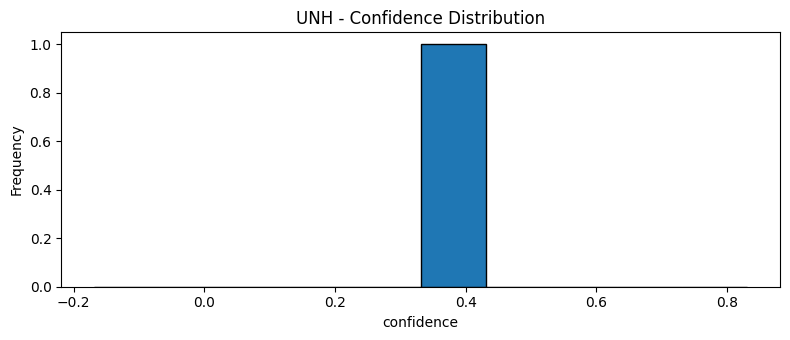

UNH weight: mean=0.000, std=nan, min=0.000, max=0.000
UNH raw_action: mean=-0.344, std=nan, min=-0.344, max=-0.344

Position Summary:
  AAPL: 2 shares @ $233.97 | Value: $467.94
  ABT: 1 shares @ $133.73 | Value: $133.73
  BRK.B: 1 shares @ $494.03 | Value: $494.03
  MDT: 1 shares @ $94.03 | Value: $94.03
  PG: 1 shares @ $158.24 | Value: $158.24
  PM: 1 shares @ $166.01 | Value: $166.01

Total Market Value: $1,513.98


In [10]:

# Report only what's in your env (default UNH)
tickers_to_report = [t.strip().upper() for t in os.getenv("TICKERS", "UNH").split(",") if t.strip()]

# Where your trade logs live; default to ARTIFACTS_DIR
ART_DIR = Path(os.getenv("ARTIFACTS_DIR", "/content"))
RESULTS_DIR = Path(os.getenv("RESULTS_DIR", str(ART_DIR)))

print("\nTrade Summary:")
for ticker in tickers_to_report:
    log_path = RESULTS_DIR / f"trade_log_{ticker}.csv"
    if not log_path.exists():
        print(f"{ticker}: no trades logged yet.")
        continue

    try:
        df = pd.read_csv(log_path, on_bad_lines="skip",
                         parse_dates=["log_time","bar_time"], infer_datetime_format=True)

        # Count by 'signal' (or 'action' if older logs)
        key = "signal" if "signal" in df.columns else ("action" if "action" in df.columns else None)
        if key:
            counts = df[key].value_counts(dropna=False).to_dict()
            print(f"{ticker}: {counts}")
        else:
            print(f"{ticker}: log present but missing 'signal'/'action' columns.")

        # Optional confidence histogram
        if "confidence" in df.columns and df["confidence"].notna().any():
            plt.figure(figsize=(8, 3.5))
            df["confidence"].dropna().plot(kind="hist", bins=10, edgecolor="black")
            plt.title(f"{ticker} - Confidence Distribution")
            plt.xlabel("confidence")
            plt.tight_layout()
            plt.show()

        # Optional: PPO-specific stats
        for col in ["weight", "raw_action"]:
            if col in df.columns and df[col].notna().any():
                s = df[col].dropna()
                print(f"{ticker} {col}: mean={s.mean():.3f}, std={s.std():.3f}, "
                      f"min={s.min():.3f}, max={s.max():.3f}")

    except Exception as e:
        print(f"{ticker}: could not summarize trades: {e}")

# --- Position Summary (unchanged) ---
try:
    if 'api' not in globals():
        api = init_alpaca()
    positions = api.list_positions()
    total_market_value = 0.0
    print("\nPosition Summary:")
    for p in positions:
        mv = float(p.market_value)
        total_market_value += mv
        print(f"  {p.symbol}: {p.qty} shares @ ${float(p.current_price):.2f} | Value: ${mv:,.2f}")
    print(f"\nTotal Market Value: ${total_market_value:,.2f}")
except Exception as e:
    print(f"Could not summarize positions: {e}")

In [8]:
picks  = pick_artifacts_for_ticker("UNH", ARTIFACTS_DIR, best_window=BEST_WINDOW_ENV)
model  = load_ppo_model(picks["model"])
vecnorm = load_vecnormalize(picks["vecnorm"]) if picks["vecnorm"] else None
print("expected obs shape:", expected_obs_shape(model, vecnorm))
import pandas as pd, os
from pathlib import Path
path = Path(os.getenv("ARTIFACTS_DIR","/content")) / "trade_log_UNH.csv"
print(path)
print(pd.read_csv(path).tail(3))


expected obs shape: (10, 2)
/content/trade_log_UNH.csv
                           log_time symbol                   bar_time  \
0  2025-09-12T20:05:15.721586+00:00    UNH  2025-09-12T16:07:00+00:00   

         signal  raw_action  weight  confidence  price     equity  dry_run  \
0  SELL_OR_HOLD   -0.344103     0.0    0.331135  359.1  100073.91        1   

         note  
0  diagnostic  


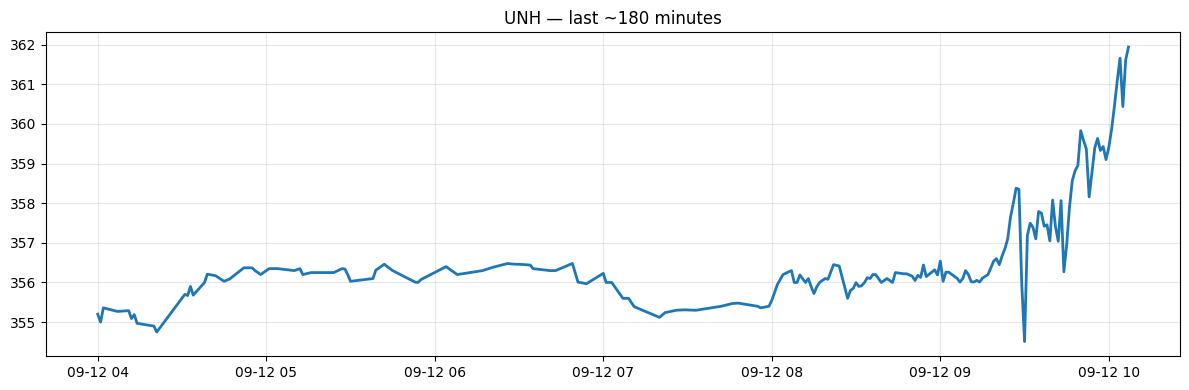

In [9]:
def plot_recent_price(api, symbol: str, minutes: int = 180):
    df = get_recent_bars(api, symbol, limit=minutes, timeframe=TimeFrame.Minute)
    if df.empty:
        print(f"No bars to plot for {symbol}."); return
    idx = df.index.tz_convert("America/New_York")
    plt.figure(figsize=(12, 4))
    plt.plot(idx, df["Close"].values, lw=2)
    plt.title(f"{symbol} — last ~{minutes} minutes")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_recent_price(api, "UNH", minutes=180)
